In [25]:
import os
import sys

In [68]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt

from pymatgen.core import Structure


In [27]:
import gudhi,gudhi.hera,gudhi.wasserstein,persim
import ripserplusplus as rpp

In [28]:
inDir="Z:/data/diverse_metals"
os.chdir(inDir)

In [29]:
def dropUnnamed(df):
    return df.loc[:,~df.columns.str.match("Unnamed")]

In [30]:
postR=pd.read_csv("post_comb_vsa-CO2-repeat.csv",index_col=0)

postR.index=[i[:i.find("_repeat")] for i in postR.index]

overall=pd.read_csv("overall_process.csv",index_col=1)
overall=dropUnnamed(overall)

overall.index=[i[:i.find("_repeat")] for i in overall.index]

In [ ]:
#False in {i.find("_repeat")!=-1 for i in overall.index} # every name contains repeat

In [ ]:
overall.head()

In [ ]:
overall.columns

In [31]:
datG=pd.read_csv("post-combustion-vsa-2-clean.csv",index_col=0)

In [32]:
datGIndex=datG.index

len(set(datGIndex) & {i[:i.find("_repeat")] for i in postR.index})

569

In [33]:
overlapCO2=set([i[:i.find("_repeat")] for i in os.listdir(f"{inDir}/for_seth/most_probable_sites")]) &set(datGIndex) 
overlapCO2

{'DB1-Cu2O8-AZO_A-fum_A_No201',
 'DB1-Cu2O8-irmof10_A-irmof20_A_No380',
 'DB1-Cu2O8-irmof7_A-pcn6_B_No18',
 'DB1-Cu2O8N2-AZO_A-DABCO_A_No15',
 'DB1-Cu2O8N2-BDC_A-irmof20_A_No306',
 'DB1-Cu2O8N2-fum_A-irmof10_A_No45',
 'DB1-Cu2O8N2-fum_A-pmof1_A_No7',
 'DB1-Cu2O8N2-irmof6_A-irmof7_A_No276',
 'DB1-Cu2O8N2-irmof6_A_No10',
 'DB1-ZIFZn-BDC_A-irmof6_A_No215',
 'DB1-ZIFZn-BDC_A-irmof6_A_No303',
 'DB1-ZIFZn-BDC_A-irmof6_A_No408',
 'DB1-ZIFZn-BDC_A-irmof6_A_No457',
 'DB1-Zn2O8-ADC_A-DPAC_A_No191',
 'DB1-Zn2O8-BTC_B-DPAC_A_No26',
 'DB1-Zn2O8-fum_A-irmof20_A_No142',
 'DB1-Zn2O8N2-irmof8_A-TED_A_No11',
 'DB1-Zn2O8N2-irmof8_A-TePM_No124',
 'DB1-Zn2O8N2-irmof8_A-TePM_No175',
 'DB1-Zn2O8N2-irmof8_A-TePM_No468',
 'DB1-Zn2O8N2-irmof8_A-TePM_No469',
 'DB10-lvtb_sym_5_mc_2_sym_5_mc_2_L_1',
 'DB10-qtz_sym_4_mc_si__L_1',
 'DB12-ABEXEM_clean',
 'DB12-ADEGIA_clean',
 'DB12-AHOKIR01_clean',
 'DB12-ALATAK_clean',
 'DB12-ALUJUN_clean',
 'DB12-ALUKAU_clean',
 'DB12-APAYUN_clean',
 'DB12-APAZOI_clean',
 'DB12-ARU

In [53]:
set(overlapCO2) &  {"DB12-BUSQIQ_freeONLY","DB12-WACLEU_clean","DB1-Al2O6-ADC_B-fum_B_No58","DB0-m3_o152_o156_f0_fsc.sym.78"}

{'DB12-BUSQIQ_freeONLY', 'DB12-WACLEU_clean'}

In [43]:
johnCO2=set([i[:i.find("_repeat")] for i in os.listdir(f"{inDir}/jjlow4/most_probable_sites")])

In [45]:
len(set([i[:i.find("_repeat")] for i in os.listdir(f"{inDir}/for_seth/most_probable_sites")]))

1012

In [69]:
fName="DB0-m1_o2_o5_f0_pcu.cif"
#viz_mof_cif_v2(f"{inDir}/cifs/{fName}")

In [70]:
#struct=CifFile.from_file(f"{inDir}/cifs/{fName}")
struct=Structure.from_file(f"{inDir}/cifs/{fName}")

C:\Users\moore\anaconda3\lib\site-packages\pymatgen\io\cif.py:1167: UserWarning:

Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.



In [ ]:
struct.distance_matrix

In [11]:
struct.cart_coords

array([[1.62607859e+00, 1.22260289e+01, 6.81531400e+00],
       [2.28665954e+01, 1.22284781e+01, 1.59243576e+01],
       [1.22909861e+01, 2.29232439e+01, 6.83550624e+00],
       [1.21951241e+01, 1.61634820e+00, 1.59608310e+01],
       [2.29237844e+01, 1.22302170e+01, 6.78691297e+00],
       [1.56869363e+00, 1.22349195e+01, 1.59525313e+01],
       [1.22955171e+01, 1.61629922e+00, 6.77661220e+00],
       [1.22005123e+01, 2.29230970e+01, 1.59031649e+01],
       [1.38086872e+01, 2.44732188e+01, 1.81620583e+01],
       [1.06818315e+01, 2.44741495e+01, 4.57722672e+00],
       [2.44407753e+01, 1.06744375e+01, 1.82001007e+01],
       [4.53103595e-02, 1.38662568e+01, 4.59876057e+00],
       [1.06235159e+01, 2.44789500e+01, 1.81884583e+01],
       [1.38671008e+01, 2.44772110e+01, 4.54889391e+00],
       [2.44473637e+01, 1.38683876e+01, 1.81418206e+01],
       [5.11884602e-02, 1.06720373e+01, 4.53863862e+00],
       [4.79797519e+00, 6.08177492e+00, 3.75521143e+00],
       [2.03086419e+01, 1.90396

In [ ]:
rppdgm=rpp.run("--format distance --dim 2",struct.distance_matrix)
rppdgm

In [ ]:
npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
persim.plot_diagrams(npdgm)

In [ ]:
mg.io.cif

In [ ]:
mg.__version__

## Forking portions from Xiaoli's plotlyMOF.py

In [ ]:
def viz_mof_cif_v2(cif_name, fract_disp=np.array([0, 0, 0]), showbackground=False, tol=0.01, bond_dist_sqr_threshold=6):
    table_dict = {}
    # https://github.com/Bowserinator/Periodic-Table-JSON
    with io.open("PeriodicTableJSON.json", "rb") as f:
        table_dict = json.load(f)
    element_df = pd.DataFrame(table_dict["elements"])
    element_df["cpk-hex"] = element_df["cpk-hex"].fillna("0000ff")
    symbol2color = dict(zip(element_df["symbol"], element_df["cpk-hex"]))
    symbol2color["X"] = "0000ff"
    idx2symbol = dict(zip(element_df["number"], element_df["symbol"]))
    idx2symbol[0] = "X"

    _cif_name = cif_name
    #cif_str = None
    with io.open(cif_name, "r", newline="\n") as cif:
        cif_str = cif.read().replace("(", "").replace(")", "")
    cif_list = cif_str.split("loop_")
    for cif_section in cif_list:
        if "_symmetry_equiv_pos_as_xyz" in cif_section:
            if len(cif_section.split("_cell_")[0].split("_symmetry_equiv_pos_as_xyz")[1].strip().split("\n")) > 1:
                cif_name = cif_name.replace(".cif", "_P1.cif")
                CifWriter(mg.Structure.from_str(cif_str, fmt="cif"), refine_struct=False).write_file(cif_name)


    M = lat_param2vec(read_cif_lattice_param(cif_name))
    A, B, C = M
    atom_df = read_cif_xyz(cif_name)
    bond_df = read_cif_bond(cif_name)

    #bond_df = None
    Natoms = len(atom_df)
    atom_df.loc[:, ["_atom_site_fract_x",
                    "_atom_site_fract_y",
                    "_atom_site_fract_z"]] = (atom_df.loc[:, ["_atom_site_fract_x",
                                                              "_atom_site_fract_y",
                                                              "_atom_site_fract_z"]].values + fract_disp) % 1# - np.array([0.5, 0.5, 0.5])) % 1
    atom_df["x"] = None
    atom_df["y"] = None
    atom_df["z"] = None
    atom_df["_atom_site_label_prefix"] = atom_df["_atom_site_label"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
    atom_df["_atom_site_label_postfix"] = atom_df["_atom_site_label"].apply(lambda x: re.findall(r"[0-9]+", x)[0])


    error_atom_index = atom_df[atom_df["_atom_site_label_prefix"]!=atom_df["_atom_site_type_symbol"]].index
    atom_df.loc[error_atom_index, "_atom_site_label"] = atom_df.loc[error_atom_index, "_atom_site_type_symbol"].astype(str) + \
                                                        atom_df.loc[error_atom_index, "_atom_site_label_postfix"].astype(str)

    unique_elements = sorted(atom_df["_atom_site_type_symbol"].unique().tolist())
    natoms_per_element = {}
    atom_idx_offset = np.zeros(Natoms, dtype=int)
    atom_df.loc[:, "_atom_site_label_save"] = atom_df.loc[:, "_atom_site_label"]
    for element in unique_elements:
        selected_index = atom_df[atom_df["_atom_site_type_symbol"]==element].index
        natoms_per_element[element] = len(selected_index)
        atom_idx_offset[selected_index] = natoms_per_element[element]

        atom_df.loc[selected_index, "_atom_site_label_postfix"] = [x for x in range(1, len(selected_index)+1)]
        atom_df.loc[selected_index, "_atom_site_label"] = element + atom_df.loc[selected_index, "_atom_site_label_postfix"].astype(str)
    # label_map_dict = dict(zip(atom_df["_atom_site_label_save"].to_list() + atom_df["_atom_site_label"].to_list(),
    #                           atom_df["_atom_site_label"].to_list() + atom_df["_atom_site_label"].to_list()))
    label_map_dict = dict(zip(atom_df["_atom_site_label_save"].to_list(),
                          atom_df["_atom_site_label"].to_list()))
    for old_label_idx in range(0, len(atom_df["_atom_site_label"])):
        if atom_df.at[old_label_idx, "_atom_site_label"] not in label_map_dict:
            label_map_dict[atom_df.at[old_label_idx, "_atom_site_label"]] = atom_df.at[old_label_idx, "_atom_site_label"]
    if type(bond_df) != type(None):
        bond_df["_geom_bond_atom_site_label_1_save"] = bond_df["_geom_bond_atom_site_label_1"]
        bond_df["_geom_bond_atom_site_label_1"] = bond_df["_geom_bond_atom_site_label_1"].map(label_map_dict)
        bond_df["_geom_bond_atom_site_label_2_save"] = bond_df["_geom_bond_atom_site_label_2"]
        bond_df["_geom_bond_atom_site_label_2"] = bond_df["_geom_bond_atom_site_label_2"].map(label_map_dict)
        bond_df["_geom_bond_atom_site_label_1_prefix"] = bond_df["_geom_bond_atom_site_label_1"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
        bond_df["_geom_bond_atom_site_label_1_postfix"] = bond_df["_geom_bond_atom_site_label_1"].apply(lambda x: re.findall(r"[0-9]+", x)[0])
        bond_df["_geom_bond_atom_site_label_2_prefix"] = bond_df["_geom_bond_atom_site_label_2"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
        bond_df["_geom_bond_atom_site_label_2_postfix"] = bond_df["_geom_bond_atom_site_label_2"].apply(lambda x: re.findall(r"[0-9]+", x)[0])
        bond_df_atom_idx_offset1 = np.zeros(len(bond_df), dtype=int)
        bond_df_atom_idx_offset2 = np.zeros(len(bond_df), dtype=int)
        for element in unique_elements:
            bond_df_selected_index = bond_df[bond_df["_geom_bond_atom_site_label_1_prefix"]==element].index
            bond_df_atom_idx_offset1[bond_df_selected_index] = natoms_per_element[element]
            bond_df_selected_index = bond_df[bond_df["_geom_bond_atom_site_label_2_prefix"]==element].index
            bond_df_atom_idx_offset2[bond_df_selected_index] = natoms_per_element[element]
        bond_df_list = [bond_df.copy(deep=True)]

    atom_df["original_label"] = atom_df["_atom_site_label"].to_list()
    atom_df["periodic_image"] = "[0, 0, 0]"
    atom_df_list = [atom_df.copy(deep=True)]

    displacement_vectors = [[0,0,1], [0,0,-1],
                            [0,1,0], [0,-1,0],
                            [1,0,0], [-1,0,0],
                            [-1,-1,0], [-1,1,0], [1,-1,0], [1,1,0],
                            [-1,0,-1], [-1,0,1], [1,0,-1], [1,0,1],
                            [0,-1,-1], [0,-1,1], [0,1,-1], [0,1,1],
                            [-1,-1,-1], [-1,-1,1], [-1,1,-1], [1,-1,-1],
                            [-1,1,1], [1,-1,1], [1,1,-1], [1,1,1]]

    for disp_i in range(0, len(displacement_vectors)):
        disp = displacement_vectors[disp_i]
        if type(bond_df) != type(None):
            _bond_df = bond_df.copy(deep=True)
            _bond_df["_geom_bond_atom_site_label_1_postfix"] = ((disp_i + 1) * bond_df_atom_idx_offset1 + \
                                                                _bond_df["_geom_bond_atom_site_label_1_postfix"].astype(int)).astype(str)
            _bond_df["_geom_bond_atom_site_label_1"] = _bond_df["_geom_bond_atom_site_label_1_prefix"] + _bond_df["_geom_bond_atom_site_label_1_postfix"]
            _bond_df["_geom_bond_atom_site_label_2_postfix"] = ((disp_i + 1) * bond_df_atom_idx_offset2 + \
                                                                _bond_df["_geom_bond_atom_site_label_2_postfix"].astype(int)).astype(str)
            _bond_df["_geom_bond_atom_site_label_2"] = _bond_df["_geom_bond_atom_site_label_2_prefix"] + _bond_df["_geom_bond_atom_site_label_2_postfix"]
            bond_df_list.append(_bond_df)

        _atom_df = atom_df.copy(deep=True)
        _atom_df.loc[:, "periodic_image"] = str(disp)
        _atom_df.loc[:, ["_atom_site_fract_x",
                         "_atom_site_fract_y",
                         "_atom_site_fract_z"]] = _atom_df.loc[:, ["_atom_site_fract_x",
                                                                   "_atom_site_fract_y",
                                                                   "_atom_site_fract_z"]].values + np.array(disp)
        _atom_df["_atom_site_label_postfix"] = ((disp_i + 1) * atom_idx_offset + _atom_df["_atom_site_label_postfix"].astype(int)).astype(str)
        _atom_df["original_label"] = _atom_df["_atom_site_label"].to_list()
        _atom_df["_atom_site_label"] = _atom_df["_atom_site_type_symbol"] + _atom_df["_atom_site_label_postfix"]

        atom_df_list.append(_atom_df)

    atom_df = pd.concat(atom_df_list, axis=0).reset_index(drop=True)
    if type(bond_df) != type(None):
        bond_df = pd.concat(bond_df_list, axis=0).reset_index(drop=True)

    atom_df.loc[:, ["x", "y", "z"]] = atom_df.loc[:, ["_atom_site_fract_x",
                                                      "_atom_site_fract_y",
                                                      "_atom_site_fract_z"]].values @ M
    unit_cell_expansion_offset = 2 # Angstrom
    critical_points = [np.array([-1, -1, -1])*unit_cell_expansion_offset,
                       np.array([1, -1, -1])*unit_cell_expansion_offset + A,
                       np.array([-1, 1, -1])*unit_cell_expansion_offset + B,
                       np.array([-1, -1, 1])*unit_cell_expansion_offset + C,
                       np.array([1, 1, -1])*unit_cell_expansion_offset + A + B,
                       np.array([-1, 1, 1])*unit_cell_expansion_offset + B + C,
                       np.array([1, -1, 1])*unit_cell_expansion_offset + A + C,
                       np.array([1, 1, 1])*unit_cell_expansion_offset + A + B + C]
    hull = Delaunay(critical_points)
    #tol=0.01

    isInHull = hull.find_simplex(atom_df.loc[:, ["x", "y", "z"]].values)>=-tol
    atom_df = atom_df[isInHull].copy(deep=True)
    atom_df.loc[:, ["x", "y", "z"]] = atom_df.loc[:, ["_atom_site_fract_x",
                                                      "_atom_site_fract_y",
                                                      "_atom_site_fract_z"]].values @ M

    bond_scatter = []

    if type(bond_df) != type(None):
        bond_df["atom1"] = None
        bond_df["atom2"] = None
        bond_df["atom1"] = bond_df["_geom_bond_atom_site_label_1"].map(dict(zip(atom_df["_atom_site_label"], atom_df.index)))
        bond_df["atom2"] = bond_df["_geom_bond_atom_site_label_2"].map(dict(zip(atom_df["_atom_site_label"], atom_df.index)))
        bond_df = bond_df.dropna()
        bond_df["atom1"] = bond_df["atom1"].astype(int)
        bond_df["atom2"] = bond_df["atom2"].astype(int)
        bond_df["dist_sqr"] = [np.sum((atom_df.loc[bond_df.at[i, "atom1"].astype(int), ["x", "y", "z"]].values - \
                                       atom_df.loc[bond_df.at[i, "atom2"].astype(int), ["x", "y", "z"]].values) ** 2) for i in bond_df.index]

        for i in bond_df.index:
            orig_label1 = atom_df.at[bond_df.at[i, "atom1"], "original_label"]
            affiliated_atoms1 = atom_df[atom_df["original_label"]==orig_label1].copy(deep=True).reset_index(drop=True)
            orig_label2 = atom_df.at[bond_df.at[i, "atom2"], "original_label"]
            affiliated_atoms2 = atom_df[atom_df["original_label"]==orig_label2].copy(deep=True).reset_index(drop=True)
            possible_bonds = pd.concat([pd.DataFrame(np.repeat(affiliated_atoms1.values, len(affiliated_atoms2), axis=0), columns=affiliated_atoms1.columns + "_1"),
                                        pd.DataFrame(np.tile(affiliated_atoms2.values, (len(affiliated_atoms1), 1)), columns=affiliated_atoms2.columns + "_2")], axis=1)
            possible_bonds["dist_sqr"] = np.sum((possible_bonds.loc[:, ["x_1", "y_1", "z_1"]].values - possible_bonds.loc[:, ["x_2", "y_2", "z_2"]].values) ** 2, axis=1)
            possible_bonds = possible_bonds[possible_bonds["dist_sqr"]<bond_dist_sqr_threshold]
            for bond_idx in possible_bonds.index:
                bond_scatter.append(
                    go.Scatter3d(
                        x=[possible_bonds.at[bond_idx, "x_1"], possible_bonds.at[bond_idx, "x_2"]],
                        y=[possible_bonds.at[bond_idx, "y_1"], possible_bonds.at[bond_idx, "y_2"]],
                        z=[possible_bonds.at[bond_idx, "z_1"], possible_bonds.at[bond_idx, "z_2"]],
                        mode="lines",
                        line=dict(
                            color='rgba(100, 100, 255, 0.5)',
                            width=5,
                        ),
                        showlegend=False,
                        hoverinfo='skip')
                )

    unit_cell = [[np.array([0, 0, 0]), A], [np.array([0, 0, 0]), B], [np.array([0, 0, 0]), C],
                 [A, A+B], [A, A+C], [B, B+A],
                 [B, B+C], [C, C+A], [C, C+B],
                 [A+B, A+B+C], [B+C, A+B+C], [A+C, A+B+C]]
    unit_cell_color = ["rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)",
                       "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)",
                       "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)",
                       "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)"]

    # XYZ arrows
    axis_length = 0.5
    V_diag = 0.25 * (A + B + C)
    x_start = -V_diag[0]
    y_start = -V_diag[1]
    z_start = -V_diag[2]
    x_end1 = (axis_length * A - V_diag)[0]
    y_end1 = (axis_length * A - V_diag)[1]
    z_end1 = (axis_length * A - V_diag)[2]
    x_end2 = (axis_length * B - V_diag)[0]
    y_end2 = (axis_length * B - V_diag)[1]
    z_end2 = (axis_length * B - V_diag)[2]
    x_end3 = (axis_length * C - V_diag)[0]
    y_end3 = (axis_length * C - V_diag)[1]
    z_end3 = (axis_length * C - V_diag)[2]
    arrows = [
        go.Scatter3d(x=[x_start, x_end1],
                     y=[y_start, y_end1],
                     z=[z_start, z_end1],
                     mode="lines+text",
                     text=["", "A"],
                     line=dict(
                         color='rgba(255, 0, 0, 1)',
                         width=5,
                     ),
                     textfont=dict(
                         color='rgba(255, 0, 0, 1)',
                         size=20,
                     ),
                     showlegend=False,
                     hoverinfo='skip',
        ),
        go.Scatter3d(x=[x_start, x_end2],
                     y=[y_start, y_end2],
                     z=[z_start, z_end2],
                     mode="lines+text",
                     text=["", "B"],
                     line=dict(
                         color='rgba(0, 255, 0, 1)',
                         width=5,
                     ),
                     textfont=dict(
                         color='rgba(0, 255, 0, 1)',
                         size=20,
                     ),
                     showlegend=False,
                     hoverinfo='skip',
        ),
        go.Scatter3d(x=[x_start, x_end3],
                     y=[y_start, y_end3],
                     z=[z_start, z_end3],
                     mode="lines+text",
                     text=["", "C"],
                     line=dict(
                         color='rgba(0, 0, 255, 1)',
                         width=5,
                     ),
                     textfont=dict(
                         color='rgba(0, 0, 255, 1)',
                         size=20,
                     ),
                     showlegend=False,
                     hoverinfo='skip',
        ),
    ]
    atom_df["color"] = "#" + atom_df["_atom_site_type_symbol"].map(symbol2color)
    data=[go.Scatter3d(x=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "x"],
                       y=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "y"],
                       z=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "z"],
                       text=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "_atom_site_type_symbol"] + "<br>" + \
                            atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "_atom_site_label"] + "<br>" + \
                            atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "periodic_image"] + "<br>was " + \
                            atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "original_label"],
                       mode='markers',
                       showlegend=True,
                       name=k,
                       marker=dict(
                           color=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "color"],
                           size=10,
                           opacity=1.0,
                       )) for k in unique_elements] + \
                       bond_scatter + [go.Scatter3d(x=np.array(unit_cell[i]).T[0],
                                                    y=np.array(unit_cell[i]).T[1],
                                                    z=np.array(unit_cell[i]).T[2],
                                                    mode="lines",
                                                    line=dict(
                                                        color=unit_cell_color[i],
                                                        width=2,
                                                    ),
                                                    showlegend=False,
                                                    hoverinfo='skip') for i in range(0, len(unit_cell))] + arrows

    xyzmin = min([atom_df["x"].min(), atom_df["y"].min(), atom_df["z"].min(), np.array(unit_cell).min(), (0-V_diag).min()])
    xyzmax = max([atom_df["x"].max(), atom_df["y"].max(), atom_df["z"].max(), np.array(unit_cell).max(), (0-V_diag).max()])
    DeltaX = xyzmax - xyzmin
    padding_xyz = DeltaX * 0.05
    fig = go.Figure(data=data)
    annotation_list = []
    fig.update_layout(
        scene = dict(
            annotations=annotation_list,
            xaxis = dict(nticks=10, range=[xyzmin-padding_xyz,xyzmax+padding_xyz],
                         backgroundcolor="rgba(80, 70, 70, 0.5)",
                         gridcolor="white",
                         showbackground=showbackground,
                         showgrid=False,
                         zeroline=False,
                         showticklabels=False,
                         visible=False,
                         #zerolinecolor="white",
                        ),
            yaxis = dict(nticks=10, range=[xyzmin-padding_xyz, xyzmax+padding_xyz],
                         backgroundcolor="rgba(70, 80, 70, 0.5)",
                         gridcolor="white",
                         showbackground=showbackground,
                         showgrid=False,
                         zeroline=False,
                         showticklabels=False,
                         visible=False,
                         #zerolinecolor="white",
                        ),
            zaxis = dict(nticks=10, range=[xyzmin-padding_xyz, xyzmax+padding_xyz],
                         backgroundcolor="rgba(70, 70, 80, 0.5)",
                         gridcolor="white",
                         showbackground=showbackground,
                         showgrid=False,
                         zeroline=False,
                         showticklabels=False,
                         visible=False,
                         #zerolinecolor="white",
                        ),
        ),
        width=1200,
        height=1200,
        margin=dict(r=10, l=10, b=10, t=10),
        showlegend=True)
    fig.update_layout(scene_aspectmode='cube',
                      paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(
        font_color="rgba(150,150,150,1)",
        title_font_color="rgba(150,150,150,1)",
        legend_title_font_color="rgba(150,150,150,1)",
    )

    if _cif_name != cif_name:
        os.remove(cif_name)

    return fig



In [ ]:
with io.open("PeriodicTableJSON.json", "rb") as f:
    table_dict = json.load(f)
element_df = pd.DataFrame(table_dict["elements"])
element_df["cpk-hex"] = element_df["cpk-hex"].fillna("0000ff")
symbol2color = dict(zip(element_df["symbol"], element_df["cpk-hex"]))
symbol2color["X"] = "0000ff"
idx2symbol = dict(zip(element_df["number"], element_df["symbol"]))
idx2symbol[0] = "X"


In [ ]:
cif_name=f"{inDir}/cifs/{fName}"
atom_df = read_cif_xyz(cif_name+".cif")

In [ ]:
atom_df

In [ ]:
fract_disp=np.array([0, 0, 0])

showbackground=False
tol=0.01
bond_dist_sqr_threshold=6

def grabAtomDF(cif_name, fract_disp=np.array([0, 0, 0]), showbackground=False, tol=0.01, bond_dist_sqr_threshold=6):



    with io.open("PeriodicTableJSON.json", "rb") as f:
        table_dict = json.load(f)
    element_df = pd.DataFrame(table_dict["elements"])
    element_df["cpk-hex"] = element_df["cpk-hex"].fillna("0000ff")
    symbol2color = dict(zip(element_df["symbol"], element_df["cpk-hex"]))
    symbol2color["X"] = "0000ff"
    idx2symbol = dict(zip(element_df["number"], element_df["symbol"]))
    idx2symbol[0] = "X"

    _cif_name = cif_name
    #cif_str = None
    with io.open(cif_name, "r", newline="\n") as cif:
        cif_str = cif.read().replace("(", "").replace(")", "")
    cif_list = cif_str.split("loop_")
    for cif_section in cif_list:
        if "_symmetry_equiv_pos_as_xyz" in cif_section:
            if len(cif_section.split("_cell_")[0].split("_symmetry_equiv_pos_as_xyz")[1].strip().split("\n")) > 1:
                cif_name = cif_name.replace(".cif", "_P1.cif")
                CifWriter(mg.Structure.from_str(cif_str, fmt="cif"), refine_struct=False).write_file(cif_name)


    M = lat_param2vec(read_cif_lattice_param(cif_name))
    A, B, C = M
    atom_df = read_cif_xyz(cif_name)
    bond_df = read_cif_bond(cif_name)

    #bond_df = None
    Natoms = len(atom_df)
    atom_df.loc[:, ["_atom_site_fract_x",
                    "_atom_site_fract_y",
                    "_atom_site_fract_z"]] = (atom_df.loc[:, ["_atom_site_fract_x",
                                                              "_atom_site_fract_y",
                                                              "_atom_site_fract_z"]].values + fract_disp) % 1# - np.array([0.5, 0.5, 0.5])) % 1
    atom_df["x"] = None
    atom_df["y"] = None
    atom_df["z"] = None
    atom_df["_atom_site_label_prefix"] = atom_df["_atom_site_label"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
    atom_df["_atom_site_label_postfix"] = atom_df["_atom_site_label"].apply(lambda x: re.findall(r"[0-9]+", x)[0])


    error_atom_index = atom_df[atom_df["_atom_site_label_prefix"]!=atom_df["_atom_site_type_symbol"]].index
    atom_df.loc[error_atom_index, "_atom_site_label"] = atom_df.loc[error_atom_index, "_atom_site_type_symbol"].astype(str) + \
                                                        atom_df.loc[error_atom_index, "_atom_site_label_postfix"].astype(str)

    unique_elements = sorted(atom_df["_atom_site_type_symbol"].unique().tolist())
    natoms_per_element = {}
    atom_idx_offset = np.zeros(Natoms, dtype=int)
    atom_df.loc[:, "_atom_site_label_save"] = atom_df.loc[:, "_atom_site_label"]
    for element in unique_elements:
        selected_index = atom_df[atom_df["_atom_site_type_symbol"]==element].index
        natoms_per_element[element] = len(selected_index)
        atom_idx_offset[selected_index] = natoms_per_element[element]

        atom_df.loc[selected_index, "_atom_site_label_postfix"] = [x for x in range(1, len(selected_index)+1)]
        atom_df.loc[selected_index, "_atom_site_label"] = element + atom_df.loc[selected_index, "_atom_site_label_postfix"].astype(str)
    # label_map_dict = dict(zip(atom_df["_atom_site_label_save"].to_list() + atom_df["_atom_site_label"].to_list(),
    #                           atom_df["_atom_site_label"].to_list() + atom_df["_atom_site_label"].to_list()))
    label_map_dict = dict(zip(atom_df["_atom_site_label_save"].to_list(),
                          atom_df["_atom_site_label"].to_list()))
    for old_label_idx in range(0, len(atom_df["_atom_site_label"])):
        if atom_df.at[old_label_idx, "_atom_site_label"] not in label_map_dict:
            label_map_dict[atom_df.at[old_label_idx, "_atom_site_label"]] = atom_df.at[old_label_idx, "_atom_site_label"]
    if type(bond_df) != type(None):
        bond_df["_geom_bond_atom_site_label_1_save"] = bond_df["_geom_bond_atom_site_label_1"]
        bond_df["_geom_bond_atom_site_label_1"] = bond_df["_geom_bond_atom_site_label_1"].map(label_map_dict)
        bond_df["_geom_bond_atom_site_label_2_save"] = bond_df["_geom_bond_atom_site_label_2"]
        bond_df["_geom_bond_atom_site_label_2"] = bond_df["_geom_bond_atom_site_label_2"].map(label_map_dict)
        bond_df["_geom_bond_atom_site_label_1_prefix"] = bond_df["_geom_bond_atom_site_label_1"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
        bond_df["_geom_bond_atom_site_label_1_postfix"] = bond_df["_geom_bond_atom_site_label_1"].apply(lambda x: re.findall(r"[0-9]+", x)[0])
        bond_df["_geom_bond_atom_site_label_2_prefix"] = bond_df["_geom_bond_atom_site_label_2"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
        bond_df["_geom_bond_atom_site_label_2_postfix"] = bond_df["_geom_bond_atom_site_label_2"].apply(lambda x: re.findall(r"[0-9]+", x)[0])
        bond_df_atom_idx_offset1 = np.zeros(len(bond_df), dtype=int)
        bond_df_atom_idx_offset2 = np.zeros(len(bond_df), dtype=int)
        for element in unique_elements:
            bond_df_selected_index = bond_df[bond_df["_geom_bond_atom_site_label_1_prefix"]==element].index
            bond_df_atom_idx_offset1[bond_df_selected_index] = natoms_per_element[element]
            bond_df_selected_index = bond_df[bond_df["_geom_bond_atom_site_label_2_prefix"]==element].index
            bond_df_atom_idx_offset2[bond_df_selected_index] = natoms_per_element[element]
        bond_df_list = [bond_df.copy(deep=True)]

    atom_df["original_label"] = atom_df["_atom_site_label"].to_list()
    atom_df["periodic_image"] = "[0, 0, 0]"
    atom_df_list = [atom_df.copy(deep=True)]

    displacement_vectors = [[0,0,1], [0,0,-1],
                            [0,1,0], [0,-1,0],
                            [1,0,0], [-1,0,0],
                            [-1,-1,0], [-1,1,0], [1,-1,0], [1,1,0],
                            [-1,0,-1], [-1,0,1], [1,0,-1], [1,0,1],
                            [0,-1,-1], [0,-1,1], [0,1,-1], [0,1,1],
                            [-1,-1,-1], [-1,-1,1], [-1,1,-1], [1,-1,-1],
                            [-1,1,1], [1,-1,1], [1,1,-1], [1,1,1]]

    for disp_i in range(0, len(displacement_vectors)):
        disp = displacement_vectors[disp_i]
        if type(bond_df) != type(None):
            _bond_df = bond_df.copy(deep=True)
            _bond_df["_geom_bond_atom_site_label_1_postfix"] = ((disp_i + 1) * bond_df_atom_idx_offset1 + \
                                                                _bond_df["_geom_bond_atom_site_label_1_postfix"].astype(int)).astype(str)
            _bond_df["_geom_bond_atom_site_label_1"] = _bond_df["_geom_bond_atom_site_label_1_prefix"] + _bond_df["_geom_bond_atom_site_label_1_postfix"]
            _bond_df["_geom_bond_atom_site_label_2_postfix"] = ((disp_i + 1) * bond_df_atom_idx_offset2 + \
                                                                _bond_df["_geom_bond_atom_site_label_2_postfix"].astype(int)).astype(str)
            _bond_df["_geom_bond_atom_site_label_2"] = _bond_df["_geom_bond_atom_site_label_2_prefix"] + _bond_df["_geom_bond_atom_site_label_2_postfix"]
            bond_df_list.append(_bond_df)

        _atom_df = atom_df.copy(deep=True)
        _atom_df.loc[:, "periodic_image"] = str(disp)
        _atom_df.loc[:, ["_atom_site_fract_x",
                         "_atom_site_fract_y",
                         "_atom_site_fract_z"]] = _atom_df.loc[:, ["_atom_site_fract_x",
                                                                   "_atom_site_fract_y",
                                                                   "_atom_site_fract_z"]].values + np.array(disp)
        _atom_df["_atom_site_label_postfix"] = ((disp_i + 1) * atom_idx_offset + _atom_df["_atom_site_label_postfix"].astype(int)).astype(str)
        _atom_df["original_label"] = _atom_df["_atom_site_label"].to_list()
        _atom_df["_atom_site_label"] = _atom_df["_atom_site_type_symbol"] + _atom_df["_atom_site_label_postfix"]

        atom_df_list.append(_atom_df)

    atom_df = pd.concat(atom_df_list, axis=0).reset_index(drop=True)
    if type(bond_df) != type(None):
        bond_df = pd.concat(bond_df_list, axis=0).reset_index(drop=True)

    atom_df.loc[:, ["x", "y", "z"]] = atom_df.loc[:, ["_atom_site_fract_x",
                                                      "_atom_site_fract_y",
                                                      "_atom_site_fract_z"]].values @ M
    unit_cell_expansion_offset = 2 # Angstrom
    critical_points = [np.array([-1, -1, -1])*unit_cell_expansion_offset,
                       np.array([1, -1, -1])*unit_cell_expansion_offset + A,
                       np.array([-1, 1, -1])*unit_cell_expansion_offset + B,
                       np.array([-1, -1, 1])*unit_cell_expansion_offset + C,
                       np.array([1, 1, -1])*unit_cell_expansion_offset + A + B,
                       np.array([-1, 1, 1])*unit_cell_expansion_offset + B + C,
                       np.array([1, -1, 1])*unit_cell_expansion_offset + A + C,
                       np.array([1, 1, 1])*unit_cell_expansion_offset + A + B + C]
    hull = Delaunay(critical_points)
    #tol=0.01

    isInHull = hull.find_simplex(atom_df.loc[:, ["x", "y", "z"]].values)>=-tol
    atom_df = atom_df[isInHull].copy(deep=True)
    atom_df.loc[:, ["x", "y", "z"]] = atom_df.loc[:, ["_atom_site_fract_x",
                                                      "_atom_site_fract_y",
                                                      "_atom_site_fract_z"]].values @ M
    return atom_df

In [ ]:
atom_df.loc[:, ["x", "y", "z"]].to_csv()

In [71]:
df=pd.read_csv(f"{inDir}/post-combustion-vsa-2-clean.csv",index_col=0)


# grab 4 bins for each, trP% of samples within regions
##
## workingCap: [0-1,1-2,2-4,4-]
## selectivity: [0-50,50-200,200-400,400-]
trP=.70
totalLen=len(df['selectivity'])
regVars=['selectivity','mmol/g_working_capacity']
bounds={"selectivity":[(0,50),(50,200),(200,400),(400,)],"mmol/g_working_capacity":[(0,1),(1,2),(2,4),(4,)]}

indexBounds={k:[] for k in bounds.keys()} #upper index for

for k in regVars:
    j=0
    bj=0
    for index,row in df.sort_values(by=[k]).iterrows():
        if bj>=len(bounds[k])-1:
            break
        elif row[k]>bounds[k][bj][1]:
            indexBounds[k].append(j)
            bj+=1
        j+=1

In [72]:
indexBounds['selectivity']

[7197, 11351, 12150]

In [ ]:
indexBounds['sel']

In [36]:
#seed, then random indices up to

np.random.seed(42)
testBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[:indexBounds[k][j]],size=round((1-trP)*indexBounds[k][j]),replace=False)))
    for j in range(1,len(indexBounds[k])):
        testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]],size=round((1-trP)*(indexBounds[k][j]-indexBounds[k][j-1])),replace=False)))
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][-1]:],size=round((1-trP)*(totalLen-indexBounds[k][-1])),replace=False)))



trainBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[:indexBounds[k][j]])-set(testBins[k][j])))
    for j in range(1,len(indexBounds[k])):
        trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]])-set(testBins[k][j])))
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][-1]:])-set(testBins[k][-1])))


#  testBins["selectivity"] -> list of sampled bins along selectivity bounds
#testBins['selectivity'][0] selects lowest selective MOFS sample <-> 4 bins, {k:{"low":[MOFIDs for low selectivity],"med"...,"high","superHigh"}

# Best and worst performers available in data

In [76]:
overlapCO2 & set(testBins["mmol/g_working_capacity"][3]) & set(testBins["selectivity"][3])

{'DB12-NEYZAU_clean'}

In [79]:
testBins["selectivity"][3] # good mof sample

['DB12-SEHZUB_clean',
 'DB12-QIWDOR_freeONLY',
 'DB12-FIPWOS_freeONLY',
 'DB12-LOKPEG_freeONLY',
 'DB12-KIDDOS_clean',
 'DB12-ETEMIB_clean',
 'DB12-EKIGOW_freeONLY',
 'DB12-OTOVAW_clean',
 'DB12-CODGAE_freeONLY',
 'DB12-VEHNED_clean',
 'DB12-HIZQEN_clean',
 'DB12-DEFRIR_clean',
 'DB12-MUVJIX_clean',
 'DB12-WEMFOL_freeONLY',
 'DB12-NEYZAU_clean']

In [77]:
overlapCO2 & set(testBins["mmol/g_working_capacity"][3])

{'DB1-Cu2O8-AZO_A-fum_A_No201',
 'DB1-Zn2O8-fum_A-irmof20_A_No142',
 'DB1-Zn2O8N2-irmof8_A-TED_A_No11',
 'DB12-NEYZAU_clean',
 'DB12-XESKAJ_clean'}

In [78]:
overlapCO2 & set(testBins["selectivity"][3])

{'DB12-CODGAE_freeONLY',
 'DB12-DEFRIR_clean',
 'DB12-FIPWOS_freeONLY',
 'DB12-HIZQEN_clean',
 'DB12-KIDDOS_clean',
 'DB12-MUVJIX_clean',
 'DB12-NEYZAU_clean',
 'DB12-VEHNED_clean',
 'DB12-WEMFOL_freeONLY'}

In [75]:
bestMOF="DB12-NEYZAU_clean"
worstMOF="DB12-CAKXUJ_clean"

## worst mofs we have available below

In [37]:
overlapCO2 & set(testBins["mmol/g_working_capacity"][0]) & set(testBins["selectivity"][0])

{'DB12-ADEGIA_clean', 'DB12-CAKXUJ_clean'}

In [ ]:
overlapCO2 & set(testBins["selectivity"][0])

In [ ]:
[j for j in testBins["mmol/g_working_capacity"][3] if j not in testBins["selectivity"][3]]

In [ ]:
list(testBins.keys())

# CIF2XYZ CSV

In [ ]:
exploredAtoms=set(os.listdir(f"{inDir}/cifPointClouds"))-{"total"}
for fName in [bestMOF,worstMOF]:
    fName+=".cif"
    cif_name=f"{inDir}/cifs/{fName}"
    atom_df = grabAtomDF(cif_name)

    atom_df.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv",index=False)

    for a in set(atom_df['_atom_site_label_prefix']):
        if a not in exploredAtoms:
            exploredAtoms.add(a)
            try:
                os.mkdir(f"{inDir}/cifPointClouds/{a}")
            except:
                pass
        try:
            subXYZ=atom_df[atom_df['_atom_site_label_prefix'] == a]
            subXYZ.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/{a}/{fName[:-3]}csv",index=False)
        except:
            print(f"error with atom lab {a} in {fName} !!")

In [ ]:
#testBins["selectivity"][3]  # good mof sample

for fName in [bestMOF,worstMOF]:#testBins["mmol/g_working_capacity"][3]:
    fName += ".cif"
    cif_name = f"{inDir}/cifs/{fName}"
    atom_df = grabAtomDF(cif_name)

    atom_df.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", index=False)

    for a in set(atom_df['_atom_site_label_prefix']):
        if a not in exploredAtoms:
            exploredAtoms.add(a)
            try:
                os.mkdir(f"{inDir}/cifPointClouds/{a}")
            except:
                pass
        try:
            subXYZ = atom_df[atom_df['_atom_site_label_prefix'] == a]
            subXYZ.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/{a}/{fName[:-3]}csv", index=False)
        except:
            print(f"error with atom lab {a} in {fName} !!")

In [ ]:
df

# Store atomic PDhash for xyz cords
- unbound (all)
- OverlapCO2
    - bound vs unbound
## TO-DO: John's predictions as well



# Way later on, this data will also be useful for building a transformer model that tries to predict DFT topology from point cloud

In [38]:
class PDhash():
    def __init__(self,res=1,diags=None, maxHdim=2,persistThresh=0):
        """upper bound resolution.
        In the case of sparce PD spaces, it may be useful to project a hash map of your dataset to the diagram space"""
        self.res=res
        self.maxD=maxHdim
        self.thresh=persistThresh
        self.bounds=[[np.inf,-np.inf] for b in range(maxHdim+1)]
        self.img={b:dict() for b in range(maxHdim+1)} # While this does impose extra time compared to np, it is ideal for map-reduce type parallelization




    def addDiagRpp(self,diag,index): ## note the index can be just an index number, or a numerical value
                                    ###although the numerical values (duplicate index) won't stack in the set
        """diag is {0:[(b,d),...],1: """
        for i in range(np.min([self.maxD+1,len(diag)])):
            for k in diag[i]:
                if k[1]-k[0] >self.thresh:
                    pt=(round(k[0]/self.res)*self.res,round(k[1]/self.res)*self.res)
                    if pt[0]<self.bounds[i][0]:
                        self.bounds[i][0]=pt[0]
                    if pt[1]>self.bounds[i][1]:
                        self.bounds[i][1]=pt[1]
                    if pt in self.img[i]:
                        if index in self.img[i][pt]:
                            self.img[i][pt][index]+=1
                        else:
                            self.img[i][pt][index]=1

                    else:
                        self.img[i][pt]={index:1}

    def addDiagCubeRips(self,crispy,index):
        """diag is [[bi,b,d,bx,by,bz,dx,dy,dz],..] """
        pass

    def __getitem__(self, item):
        if type(item)==int:
            return self.img[item]
        else:
            #return {b:self.img[b][pt] for b in range(self.maxD) for pt in self.img[b].keys()}
            return {b:self.img[b][tuple(item)] for b in range(self.maxD) if tuple(item) in self.img[b]}



In [39]:
mofNames=list(df.index)
mof2Index={i:mofNames.index(i) for i in mofNames}

744

In [ ]:
### all
saveDir='diverseTopPDhash'
failMOFs=set()
pdStack=PDhash(res=.25,diags=None, maxHdim=2,persistThresh=0)
for i in range(len(mofNames)):
    fName=mofNames[i]
    cif_name = f"{inDir}/cifs/{fName}.cif"
    try:
        struct=Structure.from_file(cif_name)
        rppdgm=rpp.run("--format distance --dim 2",struct.distance_matrix)
        npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
        pdStack.addDiagRpp(npdgm,i)
    except:
        failMOFs.add(fName)

## next do same thing for the boundCO2 files and store them seperately
### then filter out the unbound from this

In [ ]:
import pickle
topType="rppCords0_freq_QuartRes"
with open(f"{inDir}/diverseTopPDhash/pdStack_{topType}.pkl","wb") as f:
    pickle.dump(pdStackRpp,f)

In [ ]:
len(failMOFs)

In [15]:
def dm(X,Y):
    x2 = np.sum(X**2, axis=1)
    y2 = np.sum(Y**2, axis=1)
    xy=np.matmul(X,Y.T)
    return np.round(x2.reshape(-1,1) - 2*xy + y2,8)


In [ ]:
X=atom_df.loc[:, ["x", "y", "z"]].to_numpy()
X
dm(X,X).shape

In [42]:
len(overlapCO2)

356

#Do CO2 bound and compare results 
- john version and ottawa

In [54]:
saveDir='diverseTopPDhash'
failMOFs=set()
pdStack=PDhash(res=.25,diags=None, maxHdim=2,persistThresh=0)
for fName in overlapCO2:
    #fName=mofNames[i]
    cif_name = f"{inDir}/for_seth/most_probable_sites/{fName}_repeat_CO2_bs_0.cif"
    try:
        struct=Structure.from_file(cif_name)
        rppdgm=rpp.run("--format distance --dim 2",struct.distance_matrix)
        npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
        pdStack.addDiagRpp(npdgm,mof2Index[fName])
    except:
        failMOFs.add(fName)


C:\Users\moore\anaconda3\lib\site-packages\pymatgen\io\cif.py:1167: UserWarning:

Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.



In [55]:
import pickle
topType="rppCords0_freq_QuartRes_CO2Ott"
with open(f"{inDir}/diverseTopPDhash/pdStack_{topType}.pkl","wb") as f:
    pickle.dump(pdStack,f)

In [56]:
len(failMOFs)

0

In [67]:
pdStack.bounds

[[0.0, 3.25], [1.0, 14.75], [1.75, 16.0]]

(array([107.,  76.,  50.,  53.,  28.,  21.,  10.,   3.,   5.,   3.]),
 array([  5.281355 ,  81.6593715, 158.037388 , 234.4154045, 310.793421 ,
        387.1714375, 463.549454 , 539.9274705, 616.305487 , 692.6835035,
        769.06152  ]),
 <BarContainer object of 10 artists>)

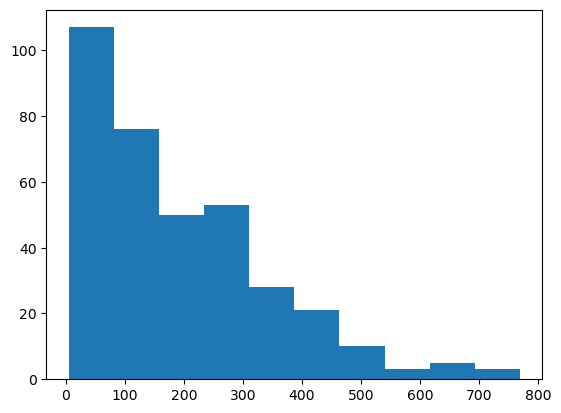

In [61]:
plt.hist(df.loc[list(overlapCO2)]['selectivity'])

(array([111.,  81.,  80.,  33.,  20.,  17.,   7.,   3.,   2.,   2.]),
 array([0.008861 , 0.8008007, 1.5927404, 2.3846801, 3.1766198, 3.9685595,
        4.7604992, 5.5524389, 6.3443786, 7.1363183, 7.928258 ]),
 <BarContainer object of 10 artists>)

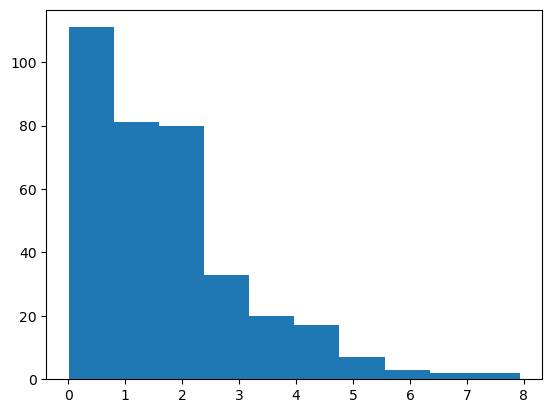

In [62]:
plt.hist(df.loc[list(overlapCO2)]['mmol/g_working_capacity'])

In [ ]:
struct=Structure.from_file(cif_name)

In [63]:
overlapCO2 & set(trainBins['selectivity'][-1])

{'DB12-BEFPAF_clean',
 'DB12-DUXMAL_clean',
 'DB12-EZULAO_clean',
 'DB12-HEKTUO01_clean',
 'DB12-HEKTUO_clean',
 'DB12-LOGBEO_freeONLY',
 'DB12-NAWWUG_clean',
 'DB12-NEYZAU_freeONLY',
 'DB12-RASKON_clean',
 'DB12-RESSAK_clean',
 'DB12-SIWTOJ_clean',
 'DB12-SOXDAM_clean',
 'DB12-TOXNIF_clean',
 'DB12-WEMBUN_freeONLY',
 'DB12-WEMCAU_freeONLY',
 'DB12-WEMDID_freeONLY',
 'DB12-WEMDUP_freeONLY',
 'DB12-WEMFAX_freeONLY',
 'DB12-WEMFEB_freeONLY',
 'DB12-XESKAJ_clean',
 'DB12-XINZEB_clean',
 'DB12-XUKLAS_clean',
 'DB12-YUTDUO_clean',
 'DB12-ZOXNEH_clean'}

In [65]:
overlapCO2 & set(trainBins['mmol/g_working_capacity'][-1])

{'DB1-Cu2O8-irmof10_A-irmof20_A_No380',
 'DB1-Cu2O8N2-AZO_A-DABCO_A_No15',
 'DB1-Cu2O8N2-BDC_A-irmof20_A_No306',
 'DB1-Cu2O8N2-fum_A-pmof1_A_No7',
 'DB1-Cu2O8N2-irmof6_A-irmof7_A_No276',
 'DB1-Cu2O8N2-irmof6_A_No10',
 'DB1-Zn2O8-BTC_B-DPAC_A_No26',
 'DB1-Zn2O8N2-irmof8_A-TePM_No124',
 'DB1-Zn2O8N2-irmof8_A-TePM_No468',
 'DB1-Zn2O8N2-irmof8_A-TePM_No469',
 'DB12-DEPXAY_clean',
 'DB12-HUFLUR_clean',
 'DB12-LOSBOM_clean',
 'DB12-NURMUJ_clean',
 'DB12-PEXFAA_clean',
 'DB12-TIXVON_clean',
 'DB12-TOXNIF_clean',
 'DB12-YEGHIC_clean',
 'DB12-YUFLIW_clean',
 'DB15-pcu_N65_E182_opt',
 'DB15-qtz-x_N139_E166_opt',
 'DB15-sxc_N139_E132_opt',
 'DB15-sxc_N139_E166_opt',
 'DB15-sxc_N77_E119_unopt',
 'DB5-hypotheticalMOF_5081767_0_0_2_29_1_14'}

In [ ]:
saveDir='diverseTopPDhash'
failMOFs=set()
pdStack2=PDhash(res=.25,diags=None, maxHdim=2,persistThresh=0)
for i in range(100):#len(mofNames)):
    fName=mofNames[i]
    cif_name = f"{inDir}/cifs/{fName}.cif"
    
    try:
        atom_df = grabAtomDF(cif_name)
        X=atom_df.loc[:, ["x", "y", "z"]].to_numpy()
        rppdgm=rpp.run("--format distance --dim 2",dm(X,X))
        npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
        pdStack2.addDiagRpp(npdgm,i)
    except:
        failMOFs.add(fName)

In [ ]:
len(failMOFs)

In [ ]:
npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
persim.plot_diagrams(npdgm)

In [ ]:
pdStack=PDhash(res=1,diags=None, maxHdim=2,persistThresh=0)
pdStack.addDiagRpp(npdgm,0)

In [ ]:
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)

In [12]:
dat=struct.cart_coords

In [13]:
ac = gudhi.AlphaComplex(dat)
st=ac.create_simplex_tree()
dgm=st.persistence()

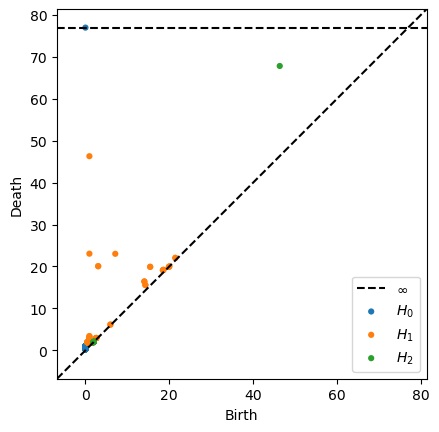

In [21]:
npdgm=[np.array([list(i[1]) for i in dgm if i[0]==b]) for b in range(3)]
persim.plot_diagrams(npdgm)

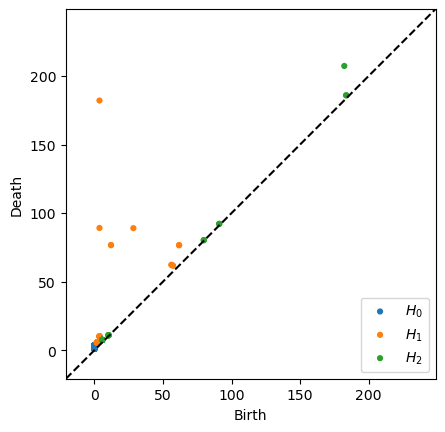

In [23]:
X=struct.cart_coords
rppdgm=rpp.run("--format distance --dim 2",np.round(dm(X,X),8))
npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
persim.plot_diagrams(npdgm)

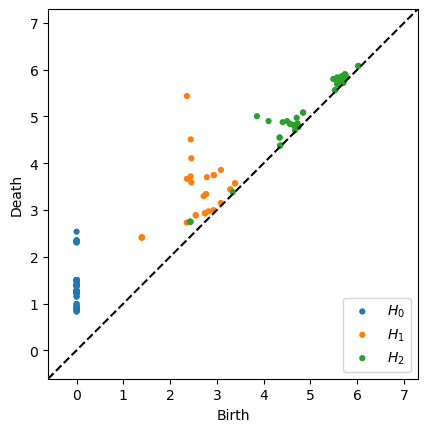

In [66]:
X=struct.cart_coords
rppdgm=rpp.run("--format distance --dim 2",struct.distance_matrix)
npdgm=[np.array([[float(rppdgm[b][k][0]),float(rppdgm[b][k][1])] for k in range(len(rppdgm[b]))])for b in rppdgm.keys()]
persim.plot_diagrams(npdgm)

In [19]:
display(dm(X,X))

array([[ 0.00000000e+00,  5.34134237e+02,  2.28171069e+02, ...,
         2.61226665e+02,  3.76560546e+00,  4.97258970e+02],
       [ 5.34134237e+02,  0.00000000e+00,  3.08828749e+02, ...,
         2.41182656e+02,  4.95567206e+02,  3.75272586e+00],
       [ 2.28171069e+02,  3.08828749e+02, -2.27373675e-13, ...,
         5.01278133e+02,  1.74764115e+02,  3.28795446e+02],
       ...,
       [ 2.61226665e+02,  2.41182656e+02,  5.01278133e+02, ...,
         0.00000000e+00,  2.80068164e+02,  1.88045113e+02],
       [ 3.76560546e+00,  4.95567206e+02,  1.74764115e+02, ...,
         2.80068164e+02,  0.00000000e+00,  4.66207993e+02],
       [ 4.97258970e+02,  3.75272586e+00,  3.28795446e+02, ...,
         1.88045113e+02,  4.66207993e+02,  2.27373675e-13]])

In [73]:
def genAlphaSlider(dat,initial=1,step=1,maximum=10,titlePrefix=""): #assume 3D for now
    ac = gudhi.AlphaComplex(dat)
    st = ac.create_simplex_tree()
    skel=list(st.get_skeleton(2))
    skel.sort(key=lambda s: s[1])
    points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
    #lims=[[np.floor(np.min(dat[:,i])),np.ceil(np.max(dat[:,i]))] for i in range(3)]
    alpha = widgets.FloatSlider(
        value = initial,
        min = 0.0,
        max = maximum,
        step = step,
        description = 'Alpha:',
        readout_format = '.4f'
    )



    b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha.value])
    triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha.value])


    pts=go.Scatter3d(
        x = points[:, 0],
        y = points[:, 1],
        z = points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color="cornflowerblue",                # set color to an array/list of desired values
            #colorscale='Viridis',   # choose a colorscale
            opacity=.9
        ),
        name='H0'

    )

    sfig=[pts]

    linepts={0:[],1:[],2:[]}
    for i in b1s:
        linepts[0].append(points[i[0],0])
        linepts[1].append(points[i[0],1])
        linepts[2].append(points[i[0],2])
        linepts[0].append(points[i[1],0])
        linepts[1].append(points[i[1],1])
        linepts[2].append(points[i[1],2])

        linepts[0].append(None)
        linepts[1].append(None)
        linepts[2].append(None)

    if len(linepts[0])>0:
        lins=go.Scatter3d(
            x=linepts[0],
            y=linepts[1],
            z=linepts[2],
            mode='lines',
            name='H1',
            marker=dict(
                size=3,
                color="#d55e00",                # set color to an array/list of desired values
                #colorscale='Viridis',   # choose a colorscale
                opacity=.9
            )
        )
        sfig.append(lins)
        if len(triangles)>0:
            mesh = go.Mesh3d(
                x = points[:, 0],
                y = points[:, 1],
                z = points[:, 2],
                i = triangles[:, 0],
                j = triangles[:, 1],
                k = triangles[:, 2],
                color="#009e73",
                opacity=.75,
                name='H2'
            )


            sfig.append(mesh)
    fig=go.Figure(sfig)
    fig.update_layout(width=800,height=800)
    #fig.show()




    def view_SC(alpha):
        if alpha==0:
            fig=go.Figure(sfig[0])
            fig.show()
        else:
            b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha])

            linepts={0:[],1:[],2:[]}
            for i in b1s:
                linepts[0].append(points[i[0],0])
                linepts[1].append(points[i[0],1])
                linepts[2].append(points[i[0],2])
                linepts[0].append(points[i[1],0])
                linepts[1].append(points[i[1],1])
                linepts[2].append(points[i[1],2])

                linepts[0].append(None)
                linepts[1].append(None)
                linepts[2].append(None)

            if len(linepts[0])>0:
                lins=go.Scatter3d(
                    x=linepts[0],
                    y=linepts[1],
                    z=linepts[2],
                    mode='lines',
                    name='H1',
                    marker=dict(
                        size=3,
                        color="#d55e00",                # set color to an array/list of desired values
                        #colorscale='Viridis',   # choose a colorscale
                        opacity=.85
                    )
                )
                if len(sfig)>1:
                    sfig[1]=lins
                else:
                    sfig.append(lins)
                triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha])
                if len(triangles)>0:
                    mesh = go.Mesh3d(
                        x = points[:, 0],
                        y = points[:, 1],
                        z = points[:, 2],
                        i = triangles[:, 0],
                        j = triangles[:, 1],
                        k = triangles[:, 2],
                        color="#009e73",
                        opacity=.5,
                        name='H2'
                    )

                    if len(sfig)>2:
                        sfig[2]=mesh
                    else:
                        sfig.append(mesh)


            fig=go.Figure(data=sfig,layout=go.Layout(width=800,height=800,
                                                     title=f"{titlePrefix}:\nSimplicial complex with radius <= {round(float(alpha),5)}",
                                                    ))

            #fig.show()
            iplot(fig)


    widgets.interact(view_SC, alpha = alpha);
    return st

In [80]:
fName=bestMOF+".cif"
tittxt=f"{fName[:-4]} AllAtoms "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=10.0, readout_format='.4f', step=0.5), …

usetex mode requires TeX.


Text(0.5, 1.0, 'DB12-NEYZAU_clean AllAtoms ')

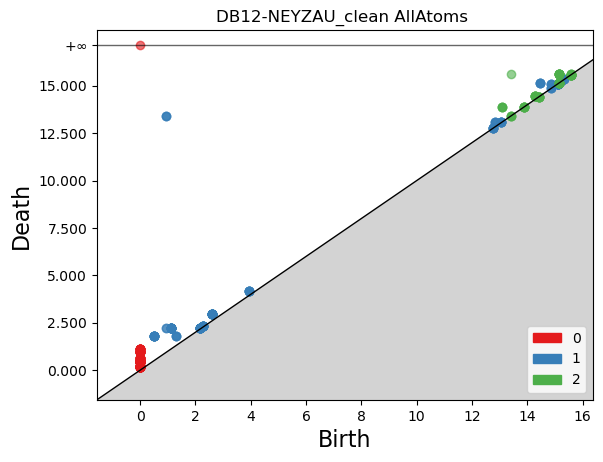

In [81]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
fName=worstMOF+".cif"
tittxt=f"{fName[:-4]} AllAtoms "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

In [ ]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
fName="DB12-VEHNED_clean.cif"
tittxt=f"{fName[:-4]} AllAtoms "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

In [ ]:

gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
fName="DB1-Zn2O8-fum_A-irmof20_A_No142.cif"
tittxt=f"{fName[:-4]} AllAtoms "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

In [ ]:

gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
fName="DB12-CUVGIK_clean.cif"
tittxt=f"{fName[:-4]} Nitrogen Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/N/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

In [ ]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
fName="DB12-CUVGIK_clean.cif"
tittxt=f"{fName[:-4]} Carbon Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/C/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

In [ ]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
fName="DB0-m2_o13_o27_f0_pcu.sym.114.cif"
tittxt=f"bad MOF: {fName[:-4]} All Atoms Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

In [ ]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
fName="DB12-VEHNED_clean.cif"
tittxt=f"bad MOF: {fName[:-4]} All Atoms Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

In [ ]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
fName="DB0-m2_o13_o27_f0_pcu.sym.114.cif"
tittxt=f"bad MOF: {fName[:-4]} Carbon Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/C/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

In [ ]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
fName="DB12-BEXSEE_clean.cif"
tittxt=f"highCap MOF: {fName[:-4]} AllAtoms Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

In [ ]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
def plot_diagrams(
    diagrams,
    plot_only=None,
    title=None,
    xy_range=None,
    labels=None,
    colormap="default",
    size=20,
    ax_color=np.array([0.0, 0.0, 0.0]),
    diagonal=True,
    lifetime=False,
    legend=True,
    show=False,
    ax=None,
    saveLoc=None
):
    """A helper function to plot persistence diagrams.

    Parameters
    ----------
    diagrams: ndarray (n_pairs, 2) or list of diagrams
        A diagram or list of diagrams. If diagram is a list of diagrams,
        then plot all on the same plot using different colors.
    plot_only: list of numeric
        If specified, an array of only the diagrams that should be plotted.
    title: string, default is None
        If title is defined, add it as title of the plot.
    xy_range: list of numeric [xmin, xmax, ymin, ymax]
        User provided range of axes. This is useful for comparing
        multiple persistence diagrams.
    labels: string or list of strings
        Legend labels for each diagram.
        If none are specified, we use H_0, H_1, H_2,... by default.
    colormap: string, default is 'default'
        Any of matplotlib color palettes.
        Some options are 'default', 'seaborn', 'sequential'.
        See all available styles with

        .. code:: python

            import matplotlib as mpl
            print(mpl.styles.available)

    size: numeric, default is 20
        Pixel size of each point plotted.
    ax_color: any valid matplotlib color type.
        See [https://matplotlib.org/api/colors_api.html](https://matplotlib.org/api/colors_api.html) for complete API.
    diagonal: bool, default is True
        Plot the diagonal x=y line.
    lifetime: bool, default is False. If True, diagonal is turned to False.
        Plot life time of each point instead of birth and death.
        Essentially, visualize (x, y-x).
    legend: bool, default is True
        If true, show the legend.
    show: bool, default is False
        Call plt.show() after plotting. If you are using self.plot() as part
        of a subplot, set show=False and call plt.show() only once at the end.
    """

    ax = ax or plt.gca()
    plt.style.use(colormap)

    xlabel, ylabel = "Birth", "Death"

    if not isinstance(diagrams, list):
        # Must have diagrams as a list for processing downstream
        diagrams = [diagrams]

    if labels is None:
        # Provide default labels for diagrams if using self.dgm_
        labels = ["$H_{{{}}}$".format(i) for i , _ in enumerate(diagrams)]

    if plot_only:
        diagrams = [diagrams[i] for i in plot_only]
        labels = [labels[i] for i in plot_only]

    if not isinstance(labels, list):
        labels = [labels] * len(diagrams)

    # Construct copy with proper type of each diagram
    # so we can freely edit them.
    diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]

    # find min and max of all visible diagrams
    concat_dgms = np.concatenate(diagrams).flatten()
    has_inf = np.any(np.isinf(concat_dgms))
    finite_dgms = concat_dgms[np.isfinite(concat_dgms)]

    # clever bounding boxes of the diagram
    if not xy_range:
        # define bounds of diagram
        ax_min, ax_max = np.min(finite_dgms), np.max(finite_dgms)
        x_r = ax_max - ax_min

        # Give plot a nice buffer on all sides.
        # ax_range=0 when only one point,
        buffer = 1 if xy_range == 0 else x_r / 5

        x_down = ax_min - buffer / 2
        x_up = ax_max + buffer

        y_down, y_up = x_down, x_up
    else:
        x_down, x_up, y_down, y_up = xy_range

    yr = y_up - y_down

    if lifetime:

        # Don't plot landscape and diagonal at the same time.
        diagonal = False

        # reset y axis so it doesn't go much below zero
        y_down = -yr * 0.05
        y_up = y_down + yr

        # set custom ylabel
        ylabel = "Lifetime"

        # set diagrams to be (x, y-x)
        for dgm in diagrams:
            dgm[:, 1] -= dgm[:, 0]

        # plot horizon line
        ax.plot([x_down, x_up], [0, 0], c=ax_color)

    # Plot diagonal
    if diagonal:
        ax.plot([x_down, x_up], [x_down, x_up], "--", c=ax_color)

    # Plot inf line
    if has_inf:
        # put inf line slightly below top
        b_inf = y_down + yr * 0.95
        ax.plot([x_down, x_up], [b_inf, b_inf], "--", c="k", label=r"$\infty$")

        # convert each inf in each diagram with b_inf
        for dgm in diagrams:
            dgm[np.isinf(dgm)] = b_inf

    # Plot each diagram
    for dgm, label in zip(diagrams, labels):

        # plot persistence pairs
        ax.scatter(dgm[:, 0], dgm[:, 1], size, label=label, edgecolor="none")

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    ax.set_xlim([x_down, x_up])
    ax.set_ylim([y_down, y_up])
    ax.set_aspect('equal', 'box')

    if title is not None:
        ax.set_title(title)

    if legend is True:
        ax.legend(loc="lower right")

    if saveLoc and type(saveLoc)==str:
        #ax.set_title(saveLoc[len(saveLoc)-saveLoc[::-1].find("\\")::saveLoc.find(".")] + ' espDist')
        plt.savefig(f'{saveLoc}',dpi=300,bbox_inches='tight')

    if show is True:
        plt.show()
